In [2]:
import torch
import pandas as pd
import numpy as np
import gdown
import zipfile
import json
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms.functional import to_pil_image
from torchvision.io import read_image 
import PIL

In [3]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

# Download dataset

In [5]:
gdown.download_folder("https://drive.google.com/drive/folders/19XjDFtOGimZjoRc42moVsJBclKBpoYDQ?usp=sharing")

Retrieving folder list


Processing file 1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI rgb-images.zip
Processing file 1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI road_waymo_trainval_v1.0.json
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From (uriginal): https://drive.google.com/uc?id=1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI
From (redirected): https://drive.google.com/uc?id=1btEnnyrgC-VFsKcsXh4E9Z4sG-68sEdI&confirm=t&uuid=8550631a-af6f-439e-9012-754c6ff5208d
To: C:\Users\mtang\Desktop\VisionFinal\road-waymo\rgb-images.zip
100%|█████████████████████████████████████| 5.10G/5.10G [10:09<00:00, 8.37MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI
From (redirected): https://drive.google.com/uc?id=1A_XLGRv7CMRw-p6OaaiUaiHg5NvQpaFI&confirm=t&uuid=1e8f796d-0c0f-4318-b4a1-85028b2723de
To: C:\Users\mtang\Desktop\VisionFinal\road-waymo\road_waymo_trainval_v1.0.json
100%|█████████████████████████████████████| 1.05G/1.05G [02:19<00:00, 7.57MB/s]
Download completed


['C:\\Users\\mtang\\Desktop\\VisionFinal\\road-waymo\\rgb-images.zip',
 'C:\\Users\\mtang\\Desktop\\VisionFinal\\road-waymo\\road_waymo_trainval_v1.0.json']

In [9]:
with zipfile.ZipFile("road-waymo/rgb-images.zip","r") as zip_ref:
    zip_ref.extractall("road-waymo/rgb-images")

In [52]:
with open("road-waymo/road_waymo_trainval_v1.0.json","r") as fp:
    dat = json.load(fp)

In [53]:
# Write a sample to view
sample = dat['db']['train_00017']
with open("road-waymo/sample.json", "w") as fp:
    json.dump(sample,fp)

In [56]:
def has_ped(frame):
    if 'annos' not in frame:
        return False
    for id,anno in frame['annos'].items():
        if 7 in anno['agent_ids']:
            return True
    return False

In [57]:
has_ped(dat['db']['train_00017']['frames']['128'])

False

In [81]:
image_dir = "road-waymo/rgb-images/rgb-images/"
videos = os.listdir(image_dir)

In [90]:
filenames = []
classifications = []
for vid in videos:
    if vid.startswith("."):
        continue
    frames = dat['db'][vid]['frames']
    for frame in frames:
        ped = has_ped(frames[frame])
        filename = f'{vid}/{frame.zfill(5)}'
        
        # skip if image doesn't exist
        fullpath = os.path.join(image_dir, filename+".jpg")
        if not os.path.isfile(fullpath):
            continue 

        filenames.append(filename)
        classifications.append(ped)
        # if ped:
        #     print(f"{vid} {frame}")
labels = pd.DataFrame({"image":filenames, "label":classifications})
labels.to_csv("./processed_labels.csv", index=False)

# Load dataset

In [4]:
def select_equal_samples(data, label_column='label'):
    """ Select equal # of pos/neg samples """
    positive_samples = data[data[label_column] == True]
    negative_samples = data[data[label_column] == False]

    # Determine the number of samples to select (minimum of positive and negative samples)
    num_samples = min(len(positive_samples), len(negative_samples))

    # Randomly select equal number of positive and negative samples without replacement
    selected_positive_samples = positive_samples.sample(n=num_samples, random_state=42, replace=False)
    selected_negative_samples = negative_samples.sample(n=num_samples, random_state=42, replace=False)

    # Concatenate the selected samples
    selected_samples = pd.concat([selected_positive_samples, selected_negative_samples])

    return selected_samples

In [5]:
class PedestrianClassificationDataset(Dataset):

    def __init__(self, labels_csv, root_dir, balance_labels=True, transform=None):
        self.labels = pd.read_csv(labels_csv)
        if balance_labels:
            self.labels = select_equal_samples(self.labels)
        self.root_dir = root_dir
        self.transform = transform
        # self.image_files = sorted(self.labels['image'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        image_name = row['image'] + ".jpg"
        image_name = os.path.join(self.root_dir, image_name) 
        image = read_image(image_name) / 255
        label = row['label']
        if self.transform:
            image = self.transform(image)
        return (image, label)

Dataset len:  5174
True


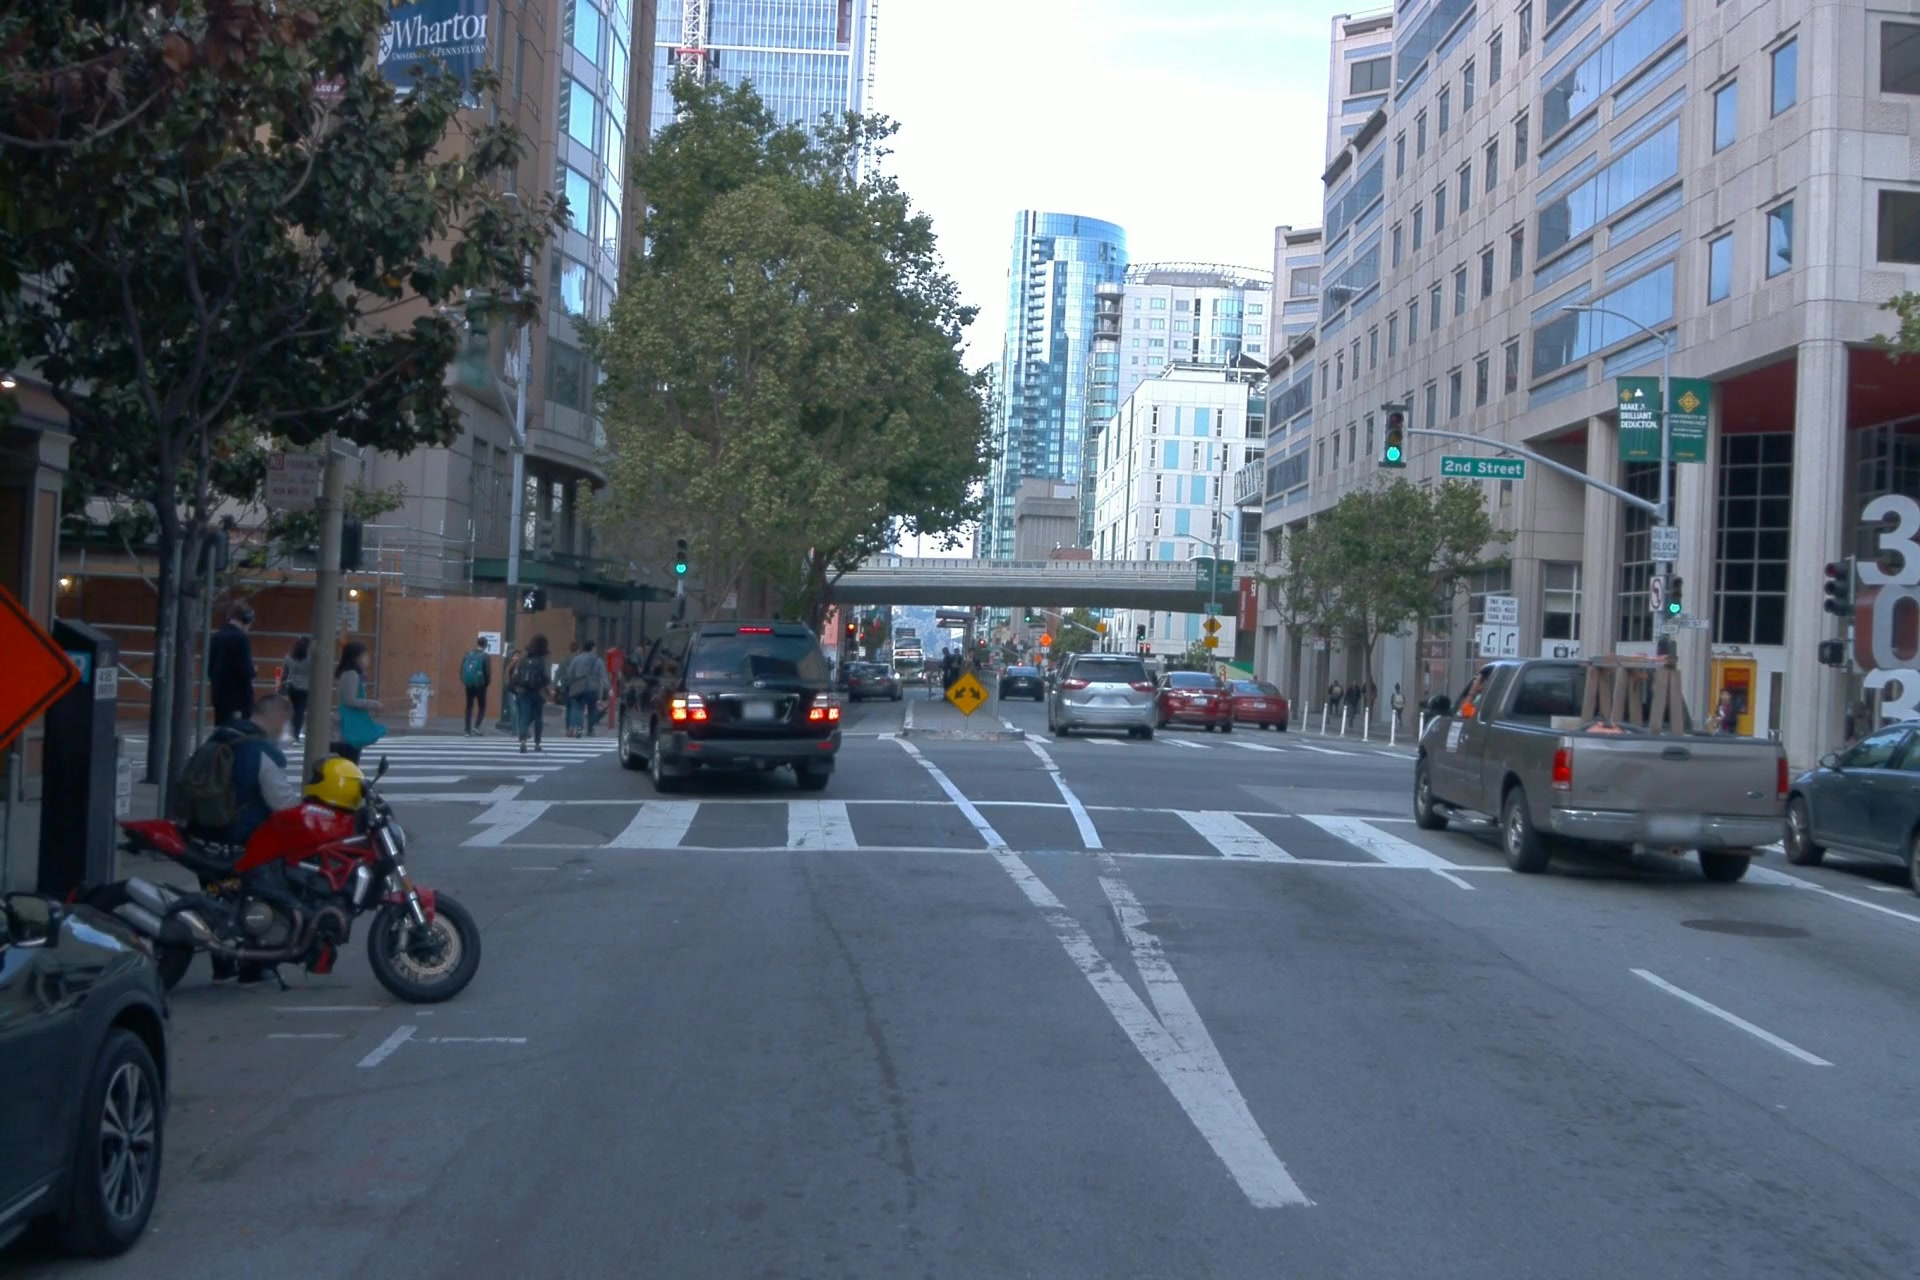

In [13]:
dataset = PedestrianClassificationDataset("./processed_labels.csv","./road-waymo/rgb-images/rgb-images/", balance_labels=True)
print(f"Dataset len:  {len(dataset)}")

sample = dataset[100]
print(sample[1])
to_pil_image(sample[0])

In [118]:
# Split training and testing
train_ratio = 0.9
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# Use random_split to split the dataset into training and testing sets.
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Experiments